In [1]:
# just here
%load_ext autoreload
%autoreload 2

In [2]:
# imports
from copy import copy
import numpy as np
import pandas as pd
import pynapple as nap
import matplotlib.pyplot as plt
import iblphotometry.loaders as loaders
import iblphotometry.plots as plots

In [3]:
# ONE instantiation
from one.api import ONE
one = ONE(base_url="https://alyx.internationalbrainlab.org", mode='remote')

In [15]:
# load data via data_loader
eids = one.search(dataset='photometry.signal.pqt', lab='wittenlab')
eid = eids[0]
print(eid)

data_loader = loaders.PhotometryLoader(one, verbose=True)
raw_photometry, regions = data_loader.load_photometry_data(eid, return_regions=True)
trials = one.load_dataset(eid, '*trials.table.pqt')

1a362471-b286-4e6b-9712-9f877d47d088
available signal bands: ['GCaMP']
available brain regions: ['Region0G', 'Region1G', 'Region2G']


In [ ]:
from iblphotometry.outlier_detection import remove_spikes
from iblphotometry.bleach_corrections import lowpass_bleachcorrect
from iblphotometry.sliding_operations import sliding_mad
from iblphotometry.pipelines import run_pipeline
from iblphotometry.helpers import zscore

pipeline = [
      (remove_spikes, dict(sd=5)),
      (lowpass_bleachcorrect, dict(correction_method='subtract-divide',
                                   filter_params=dict(N=3, Wn=0.01, btype='lowpass'))),
      (sliding_mad, dict(w_len=120,overlap=90)),
      (zscore, dict(mode='median'))
]

# run pipeline
photometry = run_pipeline(pipeline, raw_photometry['GCaMP'])


/home/georg/code/ibl-photometry/src/iblphotometry/pipelines.py:71: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _d[:, i] = pipe_func(Fc[col], **pipe_args)


<Axes: xlabel='time (s)', ylabel='signal (au)'>

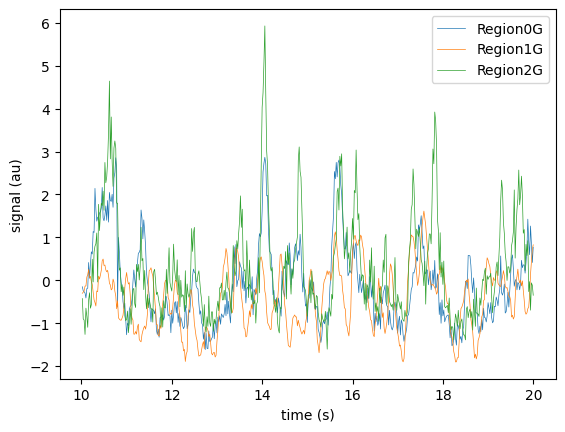

In [17]:
# view a short snippet
interval = nap.IntervalSet(start=10, end=20)
plots.plot_TsdFrame(photometry.restrict(interval))
# plots.plot_TsdFrame(photometry)

array([<Axes: ylabel='choice=-1'>, <Axes: ylabel='choice=0'>,
       <Axes: xlabel='time (s)', ylabel='choice=1'>], dtype=object)

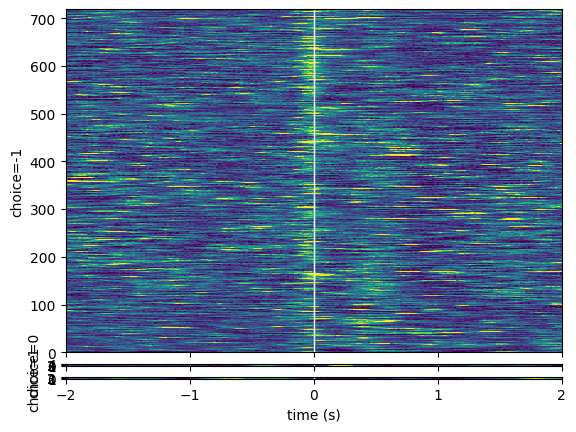

In [18]:
# plot psths
plots.plot_raster(photometry[regions[0]], trials, event='feedback_times', split_by='choice')

In [29]:
from iblphotometry.metrics import n_unique_samples, n_spikes, n_outliers

raw_photometry['GCaMP']
n_unique_samples(raw_photometry['GCaMP'][regions[0]])
# n_outliers(raw_photometry[regions[0]])

601

In [39]:
np.diff(raw_photometry['GCaMP'][regions[0]].t)

array([0.01996707, 0.01996706, 0.01996706, ..., 0.01996821, 0.02000015,
       0.0199682 ])